In [1]:
import pandas as pd;
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

pd.set_option('display.float_format', lambda x: '%.2f' % x)
path = '../../../../k6/results/monolith/'

def convert_to_MiB(value):
    if 'GiB' in value:
        return str(int(float(value.replace('GiB', '')) * 1024))
    if 'MiB' in value:
        return value.replace('MiB', '')
    if 'B' in value:
        return str(int(float(value.replace('B', '')) / 1024))
    return value

def detect_outliers(df, features, contamination=0.1):
    clf = IsolationForest(contamination=contamination, random_state=42)
    outliers = clf.fit_predict(df[features])
    return outliers == 1

def graph_row(plot_func, dataset, features, height=3, width=20):
    cols = len(features)
    fig, axes = plt.subplots(ncols=cols, figsize=(width, height))
    plt.subplots_adjust(hspace=0.3, wspace=0.3, top=0.95, bottom=0.05)
    for x, f in enumerate(features):
        plot_func(dataset, f, axes[x], idx=x)
    return plt

# 5.000 VUs

In [2]:
dirty_df = pd.read_csv(f'{path}5000/metrics.csv', sep=',')

duration = ['duration_mean', 'duration_min', 'duration_max', 'duration_count']
throughput = ['throughput_mean', 'throughput_min', 'throughput_max', 'throughput_count']
err = ['err_mean', 'err_count']

dirty_df = dirty_df[dirty_df['timestamp'] >= 30].dropna(subset=[*duration, *throughput]).reset_index(drop=True)

mask = detect_outliers(dirty_df, [*duration, *throughput])
df = dirty_df[mask].copy().reset_index(drop=True)

df.head(10)

,timestamp,cdn_cpu_percent,monolith_cpu_percent,cdn_mem_percent,monolith_mem_percent,cdn_mem_usage,monolith_mem_usage,duration_mean,duration_min,duration_max,duration_count,throughput_mean,throughput_min,throughput_max,throughput_count,err_mean,err_count
0,35,0.00,106.05,0.26,35.26,20.39,2763.00,0.92,0.65,10.27,416,83.40,83.00,84.00,417.00,0.00,0.00
1,45,0.00,105.20,0.26,35.52,20.39,2783.00,0.91,0.70,2.88,417,83.40,83.00,84.00,417.00,0.00,0.00
2,55,0.00,118.26,0.26,35.72,20.39,2799.00,0.91,0.70,3.91,417,83.20,83.00,84.00,416.00,0.00,0.00
3,60,0.00,121.28,0.26,35.82,20.39,2807.00,0.93,0.71,5.31,417,83.40,83.00,84.00,417.00,0.00,0.00
4,70,0.00,127.29,0.26,36.12,20.39,2830.00,0.90,0.69,5.97,417,83.20,83.00,84.00,416.00,0.00,0.00
5,75,0.00,104.92,0.26,36.20,20.39,2837.00,0.88,0.65,3.78,417,83.40,83.00,84.00,417.00,0.00,0.00
6,80,0.00,112.43,0.26,36.29,20.39,2843.00,0.86,0.68,5.04,416,83.40,83.00,84.00,417.00,0.00,0.00
7,85,0.00,112.90,0.26,36.46,20.39,2856.00,0.86,0.64,3.46,417,83.20,83.00,84.00,416.00,0.00,0.00
8,90,0.00,104.74,0.26,36.54,20.39,2864.00,0.88,0.66,4.86,417,83.40,83.00,84.00,417.00,0.00,0.00
9,95,0.01,110.02,0.26,36.70,20.39,2876.00,0.85,0.68,2.23,416,83.40,83.00,84.00,417.00,0.00,0.00


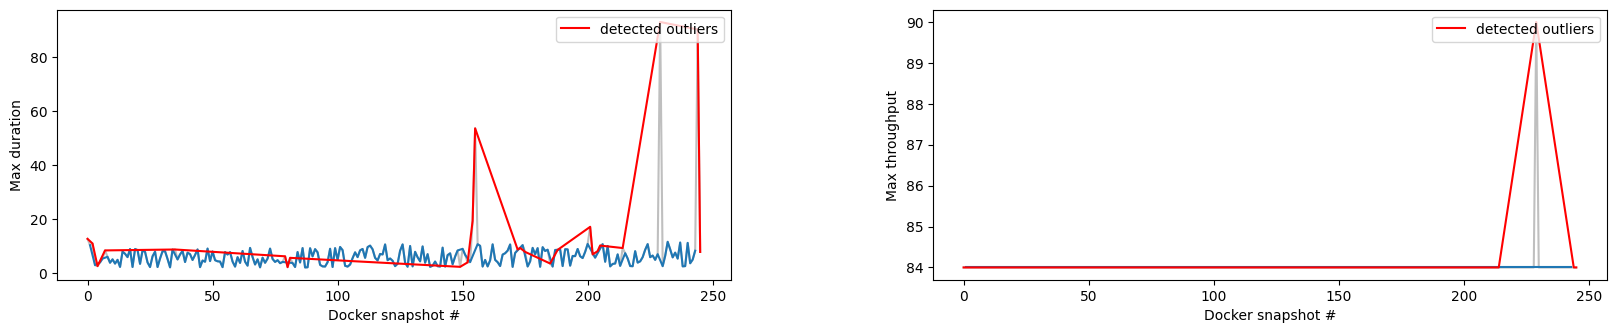

In [3]:
def plot_outliers(_df, f, loc, idx):
    loc.plot(_df[f'{f}_max'], color='gray', alpha=0.5)
    loc.plot(_df[f'{f}_max'][mask])
    loc.plot(_df[f'{f}_max'][~mask], label='detected outliers', color='red')

    loc.set_ylabel(f'Max {f}') 
    loc.set_xlabel('Docker snapshot #') 
    loc.legend(loc="upper right")

graph_row(plot_outliers, dirty_df, ['duration','throughput'])
plt.show()

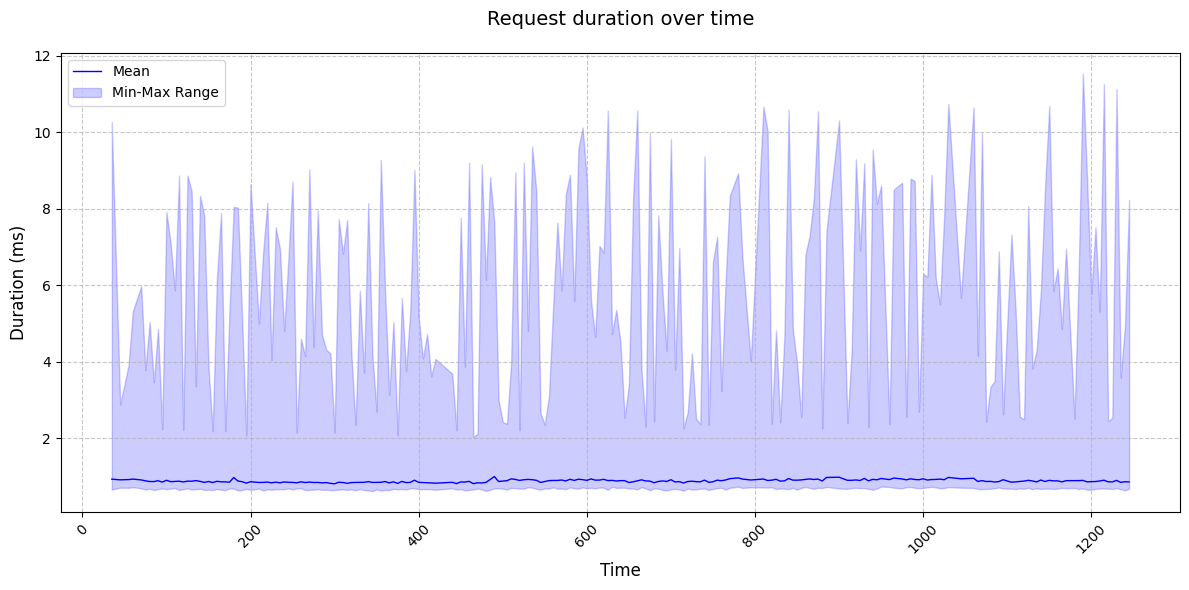

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df['timestamp'], df['duration_mean'], 'b-', label='Mean', linewidth=1)

ax.fill_between(df['timestamp'], df['duration_min'], df['duration_max'], alpha=0.2, color='blue', label='Min-Max Range')
ax.fill_between(df['timestamp'], df['duration_min'], df['duration_max'], where=(df['err_count'] > 1), color='red', alpha=0.5)

ax.set_title('Request duration over time', pad=20, size=14)
ax.set_xlabel('Time', size=12)
ax.set_ylabel('Duration (ms)', size=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

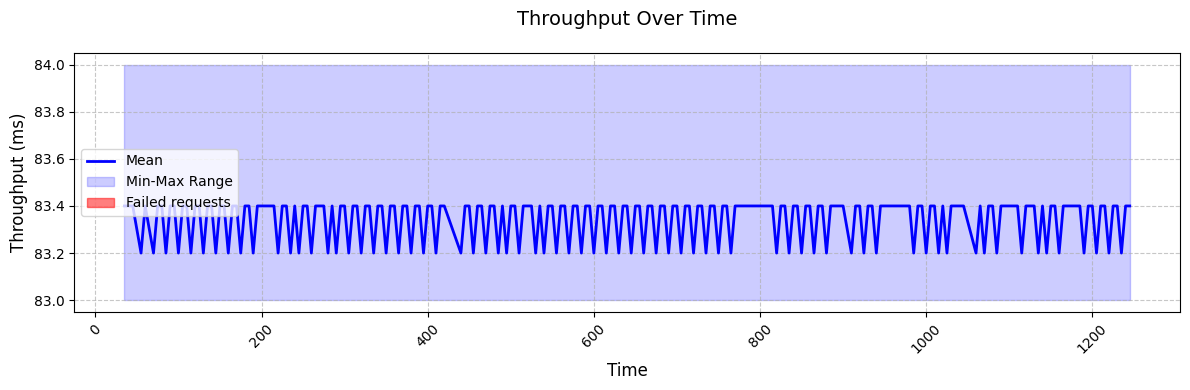

In [5]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(df['timestamp'], df['throughput_mean'], 'b-', label='Mean', linewidth=2)

ax.fill_between(df['timestamp'], df['throughput_min'], df['throughput_max'], alpha=0.2, color='blue', label='Min-Max Range')
ax.fill_between(df['timestamp'], df['throughput_min'], df['throughput_max'], where=(df['err_count'] > 1), color='red', alpha=0.5, label='Failed requests')

ax.set_title('Throughput Over Time', pad=20, size=14)
ax.set_xlabel('Time', size=12)
ax.set_ylabel('Throughput (ms)', size=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

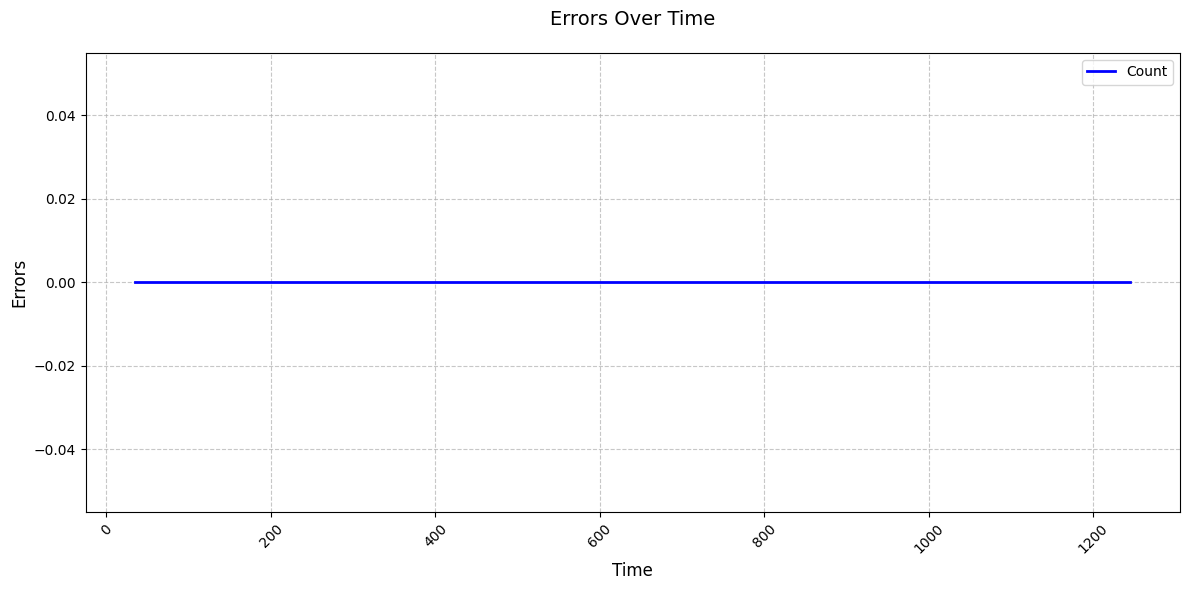

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df['timestamp'], df['err_count'], 'b-', label='Count', linewidth=2)

ax.set_title('Errors Over Time', pad=20, size=14)
ax.set_xlabel('Time', size=12)
ax.set_ylabel('Errors', size=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 10.000 VUs

In [7]:
dirty_df = pd.read_csv(f'{path}10000/metrics.csv', sep=',')

duration = ['duration_mean', 'duration_min', 'duration_max', 'duration_count']
throughput = ['throughput_mean', 'throughput_min', 'throughput_max', 'throughput_count']
err = ['err_mean', 'err_count']

dirty_df = dirty_df[dirty_df['timestamp'] >= 30].dropna(subset=[*duration, *throughput]).reset_index(drop=True)

mask = detect_outliers(dirty_df, [*duration, *throughput])
df = dirty_df[mask].copy().reset_index(drop=True)

df.head(10)

,timestamp,cdn_cpu_percent,monolith_cpu_percent,cdn_mem_percent,monolith_mem_percent,cdn_mem_usage,monolith_mem_usage,duration_mean,duration_min,duration_max,duration_count,throughput_mean,throughput_min,throughput_max,throughput_count,err_mean,err_count
0,30,NaN,NaN,NaN,NaN,NaN,NaN,0.89,0.64,16.06,834,166.60,166.00,167.00,833.00,0.00,0.00
1,40,0.00,134.10,0.83,36.51,64.88,2861.00,0.83,0.61,7.91,833,166.60,166.00,167.00,833.00,0.00,0.00
2,45,0.00,127.38,0.83,36.81,64.88,2884.00,0.80,0.61,9.05,834,166.60,166.00,167.00,833.00,0.00,0.00
3,50,0.00,115.89,0.83,37.01,64.88,2900.00,0.84,0.58,13.27,833,166.80,166.00,167.00,834.00,0.00,0.00
4,55,0.00,108.06,0.80,37.15,62.90,2911.00,0.79,0.60,10.37,833,166.60,166.00,167.00,833.00,0.00,0.00
5,60,0.00,107.94,0.80,37.50,62.90,2938.00,0.84,0.64,13.94,834,166.60,166.00,167.00,833.00,0.00,0.00
6,65,0.00,107.85,0.80,37.68,62.90,2953.00,0.78,0.61,10.18,833,166.80,166.00,167.00,834.00,0.00,0.00
7,70,0.00,108.08,0.80,38.17,62.90,2992.00,0.81,0.61,14.86,833,166.60,166.00,167.00,833.00,0.00,0.00
8,75,0.00,122.02,0.80,38.34,62.90,3005.00,0.77,0.59,12.61,834,166.60,166.00,167.00,833.00,0.00,0.00
9,80,0.00,107.64,0.80,38.59,62.90,3023.00,0.81,0.60,11.81,833,166.80,166.00,167.00,834.00,0.00,0.00


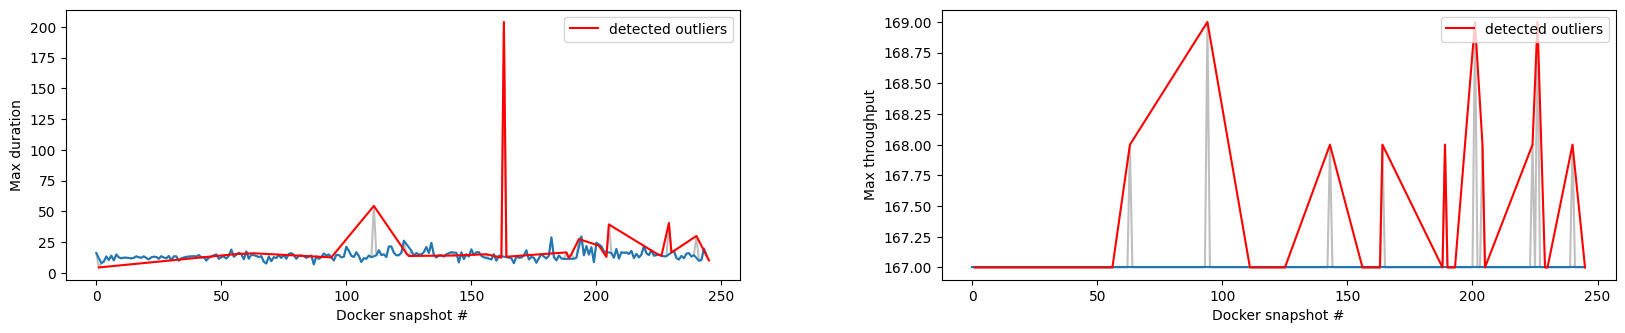

In [8]:
def plot_outliers(_df, f, loc, idx):
    loc.plot(_df[f'{f}_max'], color='gray', alpha=0.5)
    loc.plot(_df[f'{f}_max'][mask])
    loc.plot(_df[f'{f}_max'][~mask], label='detected outliers', color='red')

    loc.set_ylabel(f'Max {f}') 
    loc.set_xlabel('Docker snapshot #') 
    loc.legend(loc="upper right")

graph_row(plot_outliers, dirty_df, ['duration','throughput'])
plt.show()

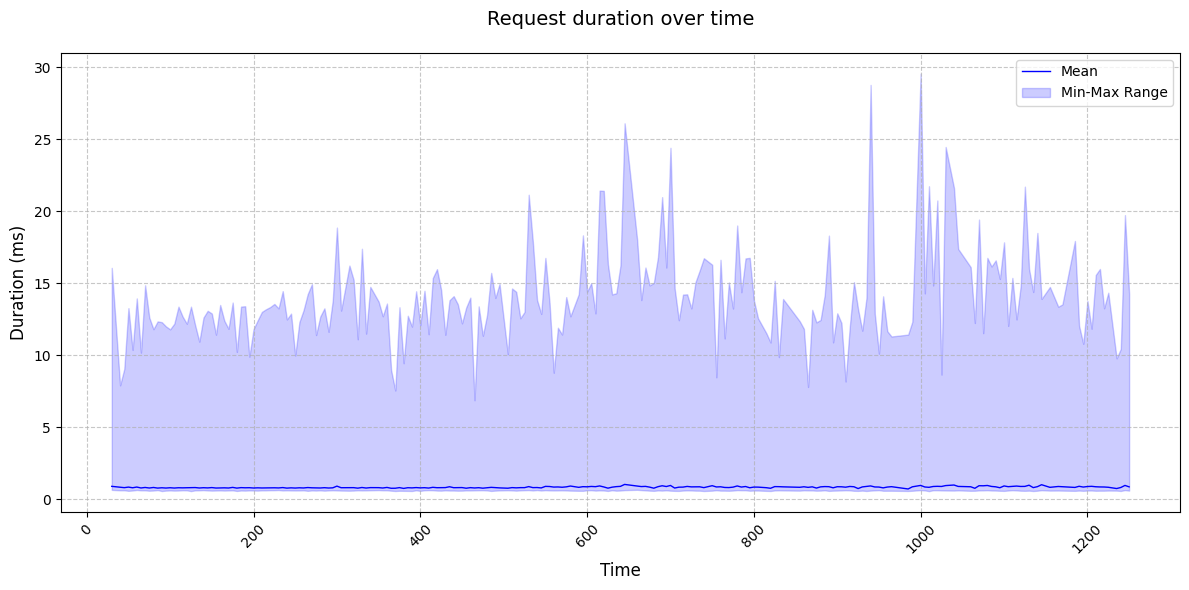

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df['timestamp'], df['duration_mean'], 'b-', label='Mean', linewidth=1)

ax.fill_between(df['timestamp'], df['duration_min'], df['duration_max'], alpha=0.2, color='blue', label='Min-Max Range')
ax.fill_between(df['timestamp'], df['duration_min'], df['duration_max'], where=(df['err_count'] > 1), color='red', alpha=0.5)

ax.set_title('Request duration over time', pad=20, size=14)
ax.set_xlabel('Time', size=12)
ax.set_ylabel('Duration (ms)', size=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

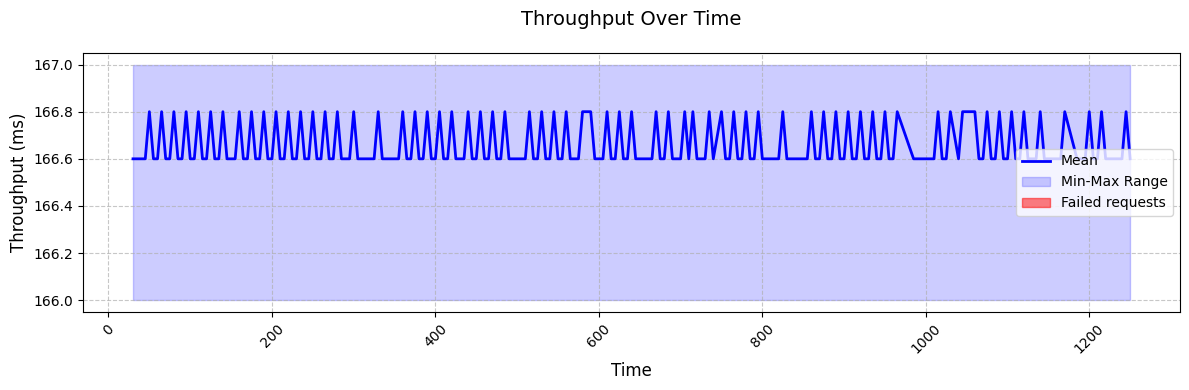

In [10]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(df['timestamp'], df['throughput_mean'], 'b-', label='Mean', linewidth=2)

ax.fill_between(df['timestamp'], df['throughput_min'], df['throughput_max'], alpha=0.2, color='blue', label='Min-Max Range')
ax.fill_between(df['timestamp'], df['throughput_min'], df['throughput_max'], where=(df['err_count'] > 1), color='red', alpha=0.5, label='Failed requests')

ax.set_title('Throughput Over Time', pad=20, size=14)
ax.set_xlabel('Time', size=12)
ax.set_ylabel('Throughput (ms)', size=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

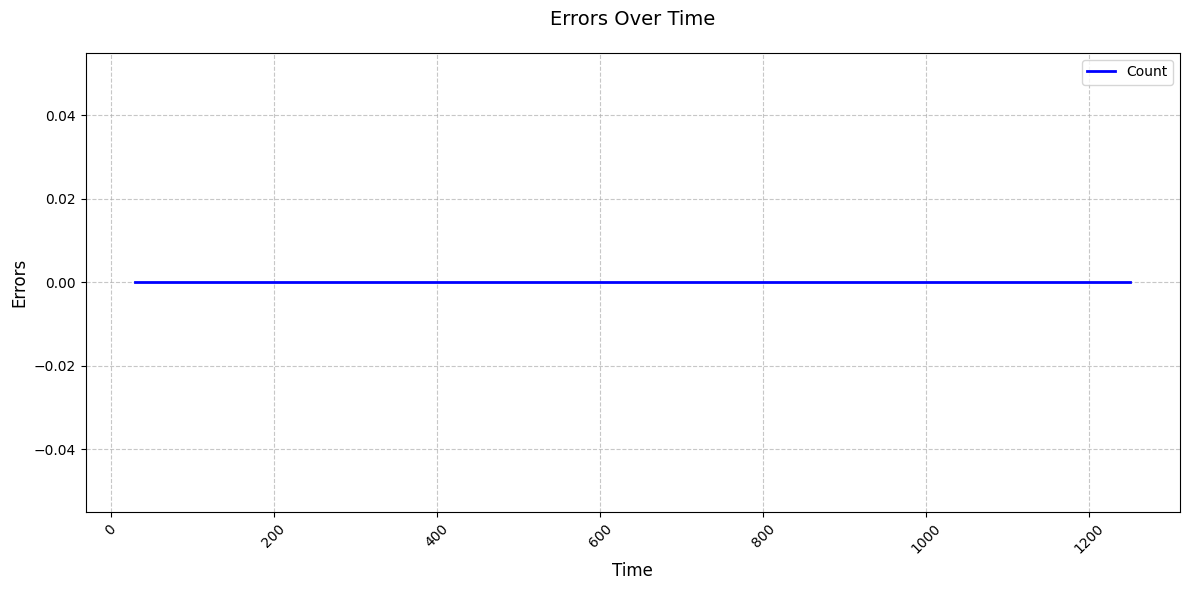

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df['timestamp'], df['err_count'], 'b-', label='Count', linewidth=2)

ax.set_title('Errors Over Time', pad=20, size=14)
ax.set_xlabel('Time', size=12)
ax.set_ylabel('Errors', size=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()